In [1]:
import math
from typing import Any, Dict, Optional, Tuple

import ee
import pandas as pd

import ee_utils
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import image_utils

from functools import partial

In [2]:
# ee.Authenticate()

In [3]:
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


# Constant

In [4]:
EXPORT = 'drive'
BUCKET = None

DHS_EXPORT_FOLDER = 'dhs_tfrecords_raw'
LSMS_EXPORT_FOLDER = 'lsms_tfrecords_raw'

In [5]:
# ========== DO NOT MODIFY THESE ==========

# input data paths
DHS_CSV_PATH = '../data/dhs_clusters.csv'
LSMS_CSV_PATH = '../data/lsms_clusters.csv'

# band names
MS_BANDS = ['SR_B1','SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'SR_B6']
# MS_BANDS = ['B2','B3','B4']

# image export parameters
PROJECTION = 'EPSG:3857'  # see https://epsg.io/3857
SCALE = 50               # export resolution: 20m/px then 1 image is 25 km square 
EXPORT_TILE_RADIUS = 127  # image dimension = (2*EXPORT_TILE_RADIUS) + 1 = 255px
CHUNK_SIZE = None         # set to a small number (<= 50) if Google Earth Engine reports memory errors

In [6]:
df = pd.read_csv('../data/district_data.csv')

In [7]:
df[df['area'] > 20000000]

,Unnamed: 0,provname,id,distname,year,area,centroid_lon,centroid_lat
1,1,HaNoi,3.0,TayHo,2010,2.695594e+07,105.819939,21.070879
3,3,HaNoi,4.0,LongBien,2010,5.955412e+07,105.894213,21.041860
5,5,HaNoi,8.0,HoangMai,2010,4.006401e+07,105.863257,20.974371
9,9,HaNoi,16.0,SocSon,2010,3.049671e+08,105.830054,21.272708
10,10,HaNoi,17.0,DongAnh,2010,1.856805e+08,105.840201,21.136775
...,...,...,...,...,...,...,...,...
2872,2872,QuangNinh,207.0,CoTo,2016,2.127775e+07,107.758189,20.990069
2873,2873,QuangNam,504.0,TayGiang,2016,9.117796e+08,107.454448,15.868061
2876,2876,SonLa,127.0,SopCop,2016,1.471983e+09,103.512246,20.887127
2877,2877,QuangNgai,531.0,MinhLong,2016,2.173683e+08,108.673917,14.948039


In [8]:
subset_df = df[(df['distname'] == 'BaDinh') & (df['year'] == 2016)].reset_index(drop=True)

In [9]:
subset_df['area']/1000000

0    9.281585
Name: area, dtype: float64

# Export Images

In [10]:
def export_images(
        df: pd.DataFrame,
        district: str,
        year: int,
        export_folder: str,
        ) -> Dict[Tuple[Any], ee.batch.Task]:
    '''
    Args
    - df: pd.DataFrame, contains columns ['lat', 'lon', 'country', 'year']
    - district: str, together with `year` determines the survey to export
    - year: int, together with `district` determines the survey to export
    - export_folder: str, name of folder for export

    Returns: dict, maps task name tuple (export_folder, country, year, chunk) to ee.batch.Task
    '''

    # Filter the df by countries and by year
    subset_df = df[(df['distname'] == district) & (df['year'] == year)].reset_index(drop=True)

    # Create a task dictionary that is to be returned
    tasks = {}
    
    # Convert df to feature collection
    fc = ee_utils.df_to_fc(subset_df)
    start_date, end_date = ee_utils.surveyyear_to_range(year)

    # create a year Landsat composite image
    roi = fc.geometry()

    # image_collection = ee_utils.Sentinel(roi, start_date=start_date, end_date=end_date).sentinel
    image_collection = ee_utils.LandsatSR(roi, start_date=start_date, end_date=end_date).merged
    
    # select the bands and reduce to median
    img = image_collection.select(MS_BANDS).median()

    # # add nightlights, latitude, and longitude bands
    # img = ee_utils.add_latlon(img)
    # img = img.addBands(ee_utils.composite_nl(year, roi))

    fname = f'{district}_{year}'
    tasks[(export_folder, district, year)] = ee_utils.get_array_patches(
        img=img, scale=SCALE, ksize=EXPORT_TILE_RADIUS,
        points=fc, export='drive',
        prefix=export_folder, fname=fname,
        bucket=None)
    return tasks

tasks = export_images(df,'LongBien',2016, DHS_EXPORT_FOLDER)

In [ ]:
ee_utils.wait_on_tasks(tasks)

### image with spatial resolution = 10m/px

(-0.5, 254.5, 254.5, -0.5)

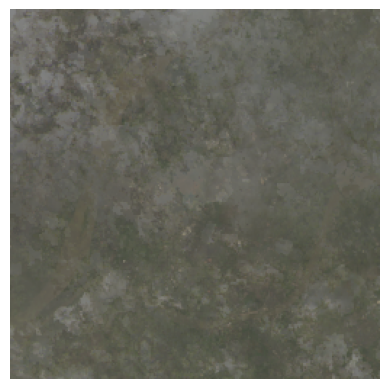

In [12]:
train_dataset = tf.data.TFRecordDataset('../LongBien_2016.tfrecord (4).gz', compression_type='GZIP')

parse_tfrecord_with_bands = partial(image_utils.parse_tfrecord, bands=MS_BANDS)

parsed_dataset = train_dataset.map(parse_tfrecord_with_bands, num_parallel_calls=5)

arr = np.zeros((255,255,3))

blue = next(iter(parsed_dataset))['SR_B2']
green = next(iter(parsed_dataset))['SR_B3']
red = next(iter(parsed_dataset))['SR_B4']

arr[:,:,0] = red
arr[:,:,1] =  green
arr[:,:,2] =  blue

plt.imshow(arr)

plt.axis('off')

(-0.5, 254.5, 254.5, -0.5)

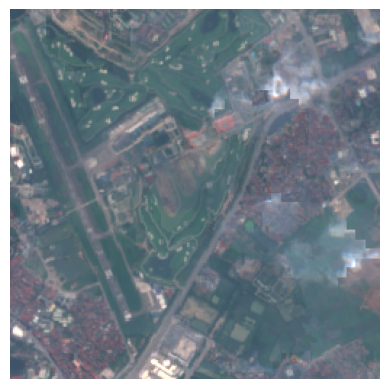

In [12]:
train_dataset = tf.data.TFRecordDataset('../LongBien_2016.tfrecord.gz', compression_type='GZIP')

parse_tfrecord_with_bands = partial(image_utils.parse_tfrecord, bands=MS_BANDS + ['maximum'])

parsed_dataset = train_dataset.map(parse_tfrecord_with_bands, num_parallel_calls=5)

arr = np.zeros((255,255,3))

def normalize_and_clip(band_data, min_val = 0.0, max_val=0.3):
    return np.clip(band_data, min_val, max_val) / (max_val - min_val)

blue = next(iter(parsed_dataset))['B2']
green = next(iter(parsed_dataset))['B3']
red = next(iter(parsed_dataset))['B4']

arr[:,:,0] = normalize_and_clip(red)
arr[:,:,1] =  normalize_and_clip(green)
arr[:,:,2] =  normalize_and_clip(blue)

plt.imshow(arr)

plt.axis('off')

### image with spatial resolution = 20m/px

(-0.5, 254.5, 254.5, -0.5)

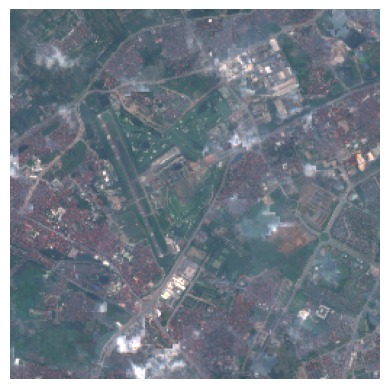

In [8]:
train_dataset = tf.data.TFRecordDataset('../LongBien_2016.tfrecord (2).gz', compression_type='GZIP')

parse_tfrecord_with_bands = partial(image_utils.parse_tfrecord, bands=MS_BANDS + ['maximum'])

parsed_dataset = train_dataset.map(parse_tfrecord_with_bands, num_parallel_calls=5)

arr = np.zeros((255,255,3))

def normalize_and_clip(band_data, min_val = 0.0, max_val=0.3):
    return np.clip(band_data, min_val, max_val) / (max_val - min_val)

blue = next(iter(parsed_dataset))['B2']
green = next(iter(parsed_dataset))['B3']
red = next(iter(parsed_dataset))['B4']

arr[:,:,0] = normalize_and_clip(red)
arr[:,:,1] =  normalize_and_clip(green)
arr[:,:,2] =  normalize_and_clip(blue)

plt.imshow(arr)

plt.axis('off')

### image with spatial resolution 30m/px

(-0.5, 254.5, 254.5, -0.5)

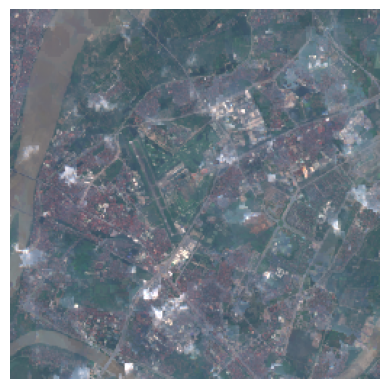

In [14]:
train_dataset = tf.data.TFRecordDataset('../LongBien_2016.tfrecord (1).gz', compression_type='GZIP')

parse_tfrecord_with_bands = partial(image_utils.parse_tfrecord, bands=MS_BANDS + ['maximum'])

parsed_dataset = train_dataset.map(parse_tfrecord_with_bands, num_parallel_calls=5)

arr = np.zeros((255,255,3))

def normalize_and_clip(band_data, min_val = 0.0, max_val=0.3):
    return np.clip(band_data, min_val, max_val) / (max_val - min_val)

blue = next(iter(parsed_dataset))['B2']
green = next(iter(parsed_dataset))['B3']
red = next(iter(parsed_dataset))['B4']

arr[:,:,0] = normalize_and_clip(red)
arr[:,:,1] =  normalize_and_clip(green)
arr[:,:,2] =  normalize_and_clip(blue)

plt.imshow(arr)

plt.axis('off')

(-0.5, 254.5, 254.5, -0.5)

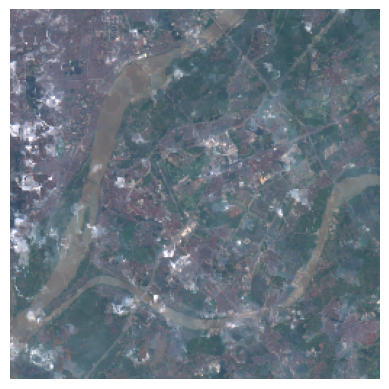

In [11]:
train_dataset = tf.data.TFRecordDataset('../LongBien_2016.tfrecord (3).gz', compression_type='GZIP')

parse_tfrecord_with_bands = partial(image_utils.parse_tfrecord, bands=MS_BANDS + ['maximum'])

parsed_dataset = train_dataset.map(parse_tfrecord_with_bands, num_parallel_calls=5)

arr = np.zeros((255,255,3))

def normalize_and_clip(band_data, min_val = 0.0, max_val=0.3):
    return np.clip(band_data, min_val, max_val) / (max_val - min_val)

blue = next(iter(parsed_dataset))['B2']
green = next(iter(parsed_dataset))['B3']
red = next(iter(parsed_dataset))['B4']

arr[:,:,0] = normalize_and_clip(red)
arr[:,:,1] =  normalize_and_clip(green)
arr[:,:,2] =  normalize_and_clip(blue)

plt.imshow(arr)

plt.axis('off')

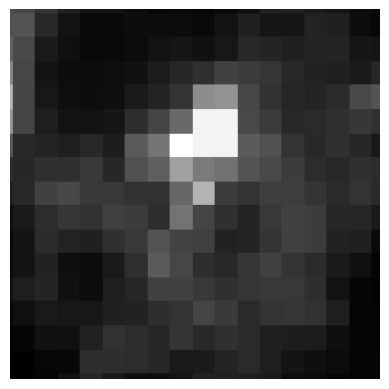

In [15]:
plt.imshow(next(iter(parsed_dataset))['maximum'], cmap='gray')
plt.axis('off')  # No axis for image
plt.show()